<a href="https://colab.research.google.com/github/christpaul94/MastersThesis_PaulChrist/blob/main/TrappedAtomsSimulation_DipolePotential.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# TrappedAtomsSimulation_DipolePotential

Author: Paul Christ

Date: 04.11.2025


In [1]:
!pip install -qq git+https://github.com/christpaul94/MastersThesis_PaulChrist.git

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 552.2/552.2 kB 10.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.5/118.5 kB 7.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 293.6/293.6 kB 25.5 MB/s eta 0:00:00


In [2]:
# Import
from TrappedAtomsSimulation.initialization import initialize_one_temp_gaussian_state, initialize_two_temp_gaussian_state
from TrappedAtomsSimulation.force_calculation import calculate_interaction_strength
from TrappedAtomsSimulation.force_calculation import pair_keops_fp
from TrappedAtomsSimulation.integrators import run_verlet_simulation_HO, solve_harmonic_analytical, run_verlet_simulation_general
from TrappedAtomsSimulation.plot_utils import plot_energy_and_error, plot_thermalization
from TrappedAtomsSimulation.trap_potential_extended import calculate_single_beam_X_AXIS, calculate_single_beam_Y_AXIS, calculate_crossed_beam_dipole_potential, calculate_U0, calculate_crossed_trap_frequencies
from TrappedAtomsSimulation.verlet_list_force_calculation import run_verlet_list_simulation_general

import torch
import math
import time

[KeOps] Compiling cuda jit compiler engine ... OK
[pyKeOps] Compiling nvrtc binder for python ... OK


In [3]:
### troch settings
torch.backends.cuda.matmul.allow_tf32 = True
torch.backends.cudnn.allow_tf32 = True
torch.backends.cudnn.benchmark = True

import torch._dynamo
torch._dynamo.config.capture_scalar_outputs = True


In [4]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
dtype = torch.float32
kB = 1.380649e-23  # J/K
c_light = 299_792_458.0 # m/s
pi = math.pi

## Trap

In [5]:
trap_frequencies_Hz = (1000.0, 1050.0, 1200.0)
# Atommasse 87Rb
m_rb87 = 1.44160648e-25  # kg

# D1 Linie
omega_0_D1 = 2 * pi * 377.1074635e12 # rad/s
Gamma_D1 = 2 * pi * 5.746e6         # rad/s

# D2 Linie
omega_0_D2 = 2 * pi * 384.230484e12 # rad/s
Gamma_D2 = 2 * pi * 6.065e6         # rad/s

# Laserfrequenz
omega_L = 2 * pi * 280.179867e12    # rad/s




# Strahl 1 (X-Achse)
P_x = 5.18      # W
w0_x_SI = 41e-6   # m (41 µm)
zR_x_SI = 4.94e-3 # m (4.94 mm)

# Strahl 2 (Y-Achse)
P_y = 6.52      # W
w0_y_SI = 46e-6   # m (46 µm)
zR_y_SI = 6.21e-3 # m (6.21 mm)


# Gemeinsame Atom/Laser-Parameter
atom_laser_params = {
    "omega_L": omega_L,
    "omega_0_D1": omega_0_D1, "Gamma_D1": Gamma_D1,
    "omega_0_D2": omega_0_D2, "Gamma_D2": Gamma_D2
}



# Berechne U0 für Strahl 1
U0_1_SI = calculate_U0(P=P_x, w0=w0_x_SI, **atom_laser_params)

# Berechne U0 für Strahl 2
U0_2_SI = calculate_U0(P=P_y, w0=w0_y_SI, **atom_laser_params)

U0_1_in_uK = (U0_1_SI / kB) * 1e6
U0_2_in_uK = (U0_2_SI / kB) * 1e6

print("--- Berechnete Potentialtiefen (U0) ---")
print(f"  Strahl 1: {U0_1_in_uK:.1f} µK ")
print(f"  Strahl 2: {U0_2_in_uK:.1f} µK ")

trap_frequencies = calculate_crossed_trap_frequencies(
    U0_1=U0_1_SI, w0_1=w0_x_SI, zR_1=zR_x_SI,
    U0_2=U0_2_SI, w0_2=w0_y_SI, zR_2=zR_y_SI,
    m=m_rb87
)

print("\n--- Berechnete Frequenzen (basierend auf U0) ---")
print(f"  f_x: {trap_frequencies['freq_x_hz']:.0f} Hz")
print(f"  f_y: {trap_frequencies['freq_y_hz']:.0f} Hz")
print(f"  f_z: {trap_frequencies['freq_z_hz']:.0f} Hz")
print(f"  f_mean: {trap_frequencies['freq_mean_hz']:.0f} Hz")


--- Berechnete Potentialtiefen (U0) ---
  Strahl 1: -294.8 µK 
  Strahl 2: -294.8 µK 

--- Berechnete Frequenzen (basierend auf U0) ---
  f_x: 1163 Hz
  f_y: 1305 Hz
  f_z: 1747 Hz
  f_mean: 1384 Hz


### One group

--- Starte Simulation mit N=20000 Teilchen ---
--- Skalierung basierend auf T = 1.60e-04 K ---
Längenskala L0: 1.69e-05 m, Energieskala E0: 2.21e-27 J, Zeitskala T0: 1.37e-04 s
Initialisiere 20000 Teilchen bei T = 1.60e-04 K
--- Initialisierung abgeschlossen ---

{'t_values': tensor([0.0000, 0.0731, 0.1461, 0.2192, 0.2922, 0.3653, 0.4383, 0.5114, 0.5844,
        0.6575, 0.7305, 0.8036, 0.8767, 0.9497, 1.0228, 1.0958, 1.1689, 1.2419,
        1.3150, 1.3880, 1.4611, 1.5341, 1.6072, 1.6803, 1.7533, 1.8264, 1.8994,
        1.9725, 2.0455, 2.1186, 2.1916, 2.2647, 2.3377, 2.4108, 2.4839, 2.5569,
        2.6300, 2.7030, 2.7761, 2.8491, 2.9222, 2.9952, 3.0683, 3.1413, 3.2144,
        3.2875, 3.3605, 3.4336, 3.5066, 3.5797, 3.6527, 3.7258, 3.7988, 3.8719,
        3.9450, 4.0180, 4.0911, 4.1641, 4.2372, 4.3102, 4.3833, 4.4563, 4.5294,
        4.6024, 4.6755, 4.7486, 4.8216, 4.8947, 4.9677, 5.0408, 5.1138, 5.1869,
        5.2599, 5.3330, 5.4060, 5.4791, 5.5522, 5.6252, 5.6983, 5.7713, 5.8444,
   

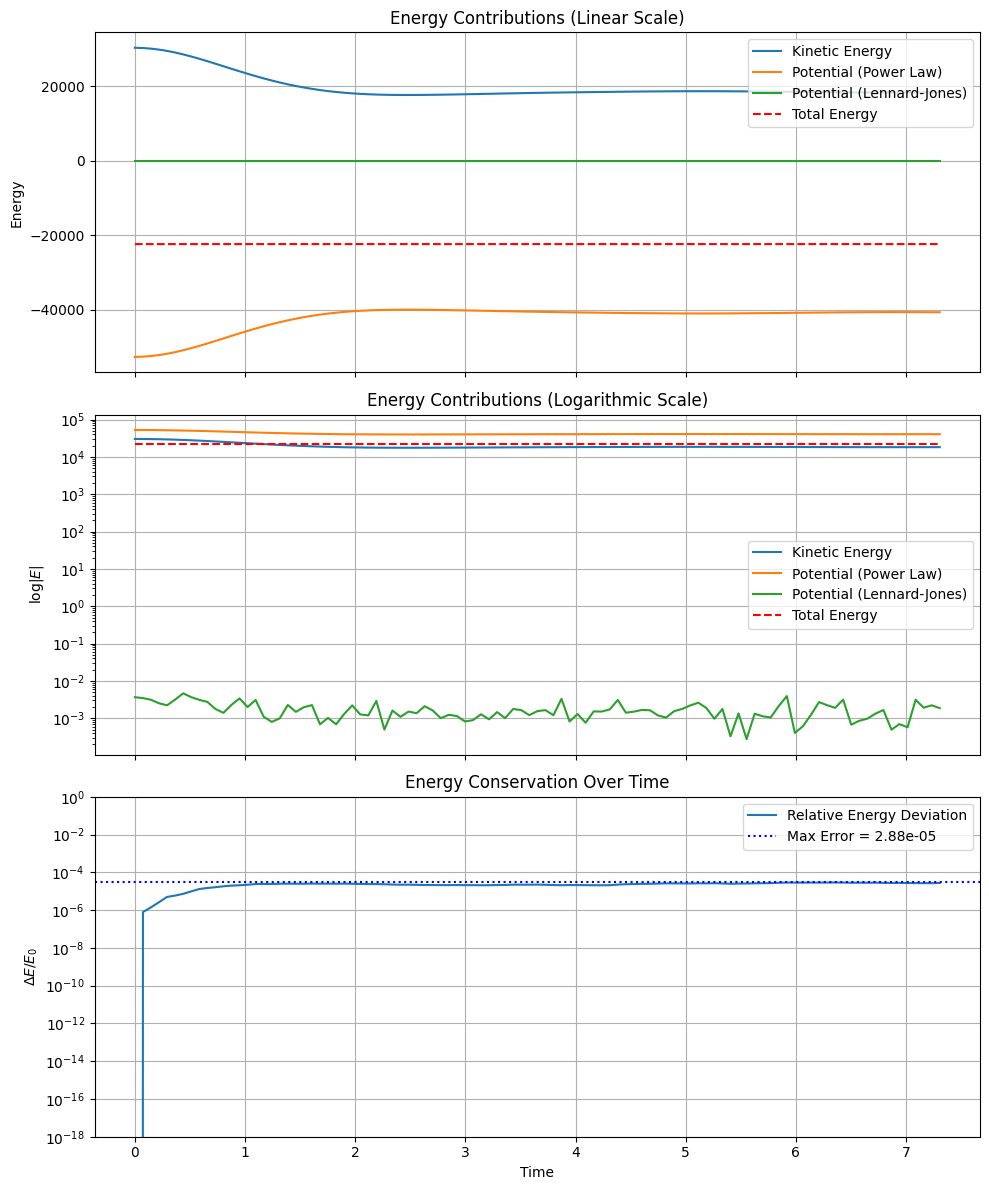

tensor(2.8833e-05, device='cuda:0')

In [6]:
N_PARTICLES = 20000         # Kleinere Zahl für einen schnellen Test
TEMPERATURE_K = 160e-6       # 100 nK
SIMULATION_TIME_S = 0.001     # 10 ms
TIMESTEP_S = 1e-5            # Speichern alle 0.1 ms
SUBSTEPS = 5

# Frequenzen der HARMONISCHEN NÄHERUNG (aus PDF Tabelle 2.3)
# Wird für die Initialisierung der Gauß-Wolke benötigt
TRAP_FREQUENCIES_HZ = (trap_frequencies['freq_x_hz'],trap_frequencies['freq_y_hz'],trap_frequencies['freq_z_hz'])

# --- 3. Physikalische Wechselwirkungsparameter ---

r0_phys,C_phys = calculate_interaction_strength(10)

print(f"--- Starte Simulation mit N={N_PARTICLES} Teilchen ---")
# --- 4. Initialisierung ---
# Bestimmt L0, E0, T0, q0, p0, r_dimless, c_dimless
sim_init_params = initialize_one_temp_gaussian_state(
    n_particles=N_PARTICLES,
    temp_k=TEMPERATURE_K,
    omega_phys_hz=TRAP_FREQUENCIES_HZ, # Verwendet harmonische Freq. für Start
    t_end_s=SIMULATION_TIME_S,
    dt_s=TIMESTEP_S,
    r0_phys=r0_phys,
    C_phys=C_phys,
    precision=torch.float32,
    device=device
)
print(sim_init_params)
# --- 5. Parameter-Dictionaries für den Integrator erstellen ---

# Skalierungsfaktoren extrahieren
L0 = sim_init_params['L0_m']
E0 = sim_init_params['E0_J']
T0 = sim_init_params['T0_s']

Delta_D2 = omega_L - omega_0_D2

# a) Parameter für die Dipolfalle
trap_params_extended = {
    "P_x": P_x, "P_y": P_y,
    "w0_x": w0_x_SI, "w0_y": w0_y_SI,
    "s0_x": zR_x_SI, "s0_y": zR_y_SI,
    "omega_L": omega_L,
    "omega_0_D1": omega_0_D1, "Gamma_D1": Gamma_D1,
    "omega_0_D2": omega_0_D2, "Gamma_D2": Gamma_D2,
    "L0": L0,
    "E0": E0
}

# b) Parameter für die Paar-Wechselwirkung (von Initializer übernommen)
pair_params = sim_init_params['pair_force_params']

# c) Parameter für den Integrator selbst
integrator_params = {
    "t_values": sim_init_params['t_values'],
    "q0": sim_init_params['q0'],
    "p0": sim_init_params['p0'],
    "precision_type": sim_init_params['precision_type'],
    "device": sim_init_params['device'],
    "substeps": SUBSTEPS,
}

# --- 6. Simulationsaufruf ---
print("Starte Simulation mit realistischer Dipolfalle...")
start_time = time.perf_counter()

results = run_verlet_simulation_general(
    trap_force_func=calculate_crossed_beam_dipole_potential,
    trap_force_params=trap_params_extended,

    pair_force_func=pair_keops_fp,
    pair_force_params=pair_params,

    **integrator_params
)

duration = time.perf_counter() - start_time
print(f"Simulation abgeschlossen in {duration:.2f} Sekunden.")

# --- 7. Ergebnisse plotten ---
plot_energy_and_error(
    results['times'],
    results['kinetic_energy'],
    results['potential_energy_trap'],
    results['potential_energy_pair']
)




--- Starte Simulation mit N=120000 Teilchen ---
--- Skalierung basierend auf T = 1.00e-05 K ---
Längenskala L0: 4.23e-06 m, Energieskala E0: 1.38e-28 J, Zeitskala T0: 1.37e-04 s
Initialisiere 120000 Teilchen bei T = 1.00e-05 K
--- Initialisierung abgeschlossen ---

{'t_values': tensor([0.0000, 0.0731, 0.1461, 0.2192, 0.2922, 0.3653, 0.4383, 0.5114, 0.5844,
        0.6575, 0.7305, 0.8036, 0.8767, 0.9497, 1.0228, 1.0958, 1.1689, 1.2419,
        1.3150, 1.3880, 1.4611, 1.5341, 1.6072, 1.6803, 1.7533, 1.8264, 1.8994,
        1.9725, 2.0455, 2.1186, 2.1916, 2.2647, 2.3377, 2.4108, 2.4839, 2.5569,
        2.6300, 2.7030, 2.7761, 2.8491, 2.9222, 2.9952, 3.0683, 3.1413, 3.2144,
        3.2875, 3.3605, 3.4336, 3.5066, 3.5797, 3.6527, 3.7258, 3.7988, 3.8719,
        3.9450, 4.0180, 4.0911, 4.1641, 4.2372, 4.3102, 4.3833, 4.4563, 4.5294,
        4.6024, 4.6755, 4.7486, 4.8216, 4.8947, 4.9677, 5.0408, 5.1138, 5.1869,
        5.2599, 5.3330, 5.4060, 5.4791, 5.5522, 5.6252, 5.6983, 5.7713, 5.8444,
 

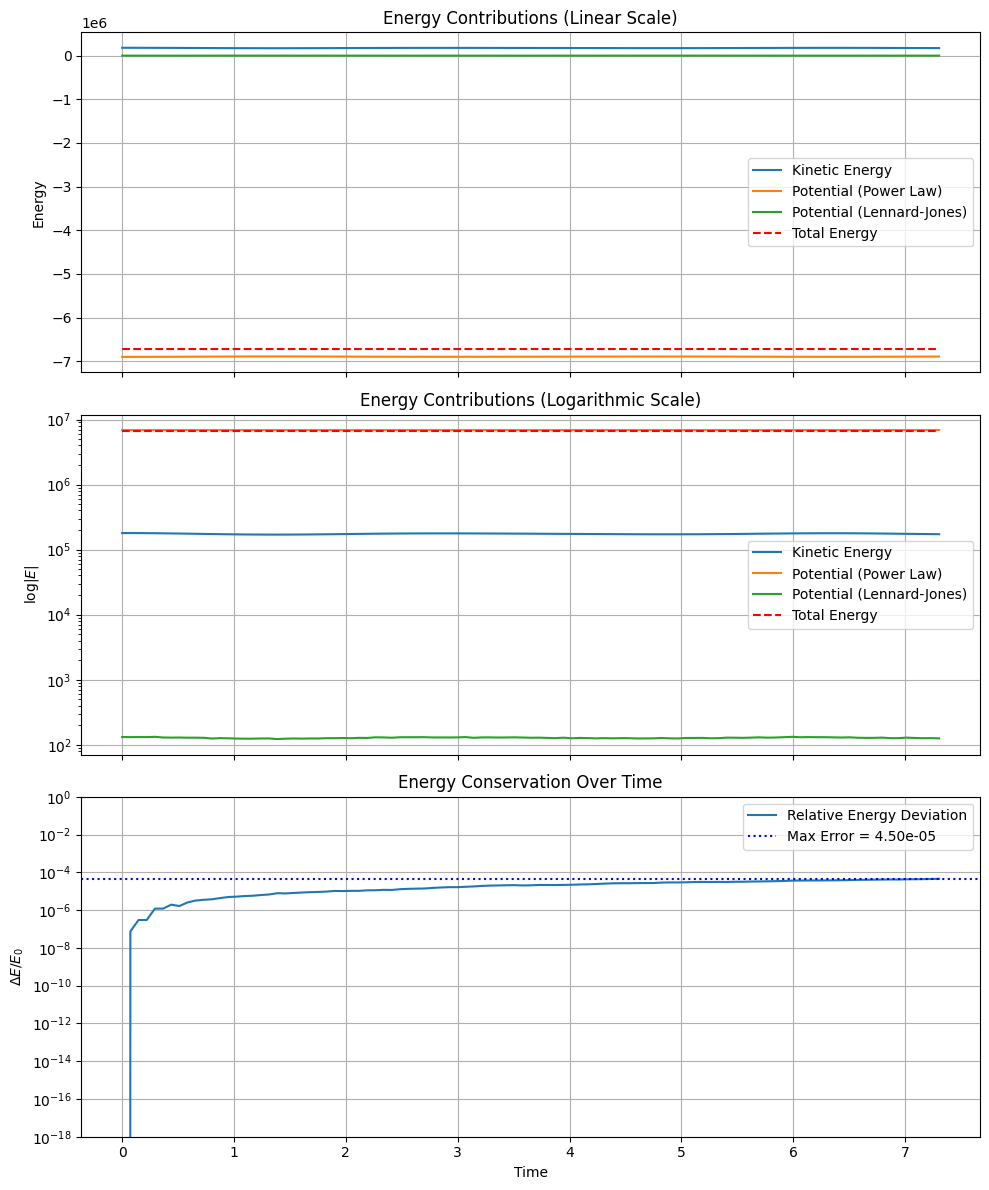

tensor(4.5011e-05, device='cuda:0')

In [7]:

# --- 1. Simulations-Setup (wie in deinem Beispiel) ---
N_PARTICLES = 120000      # Kleinere Zahl für einen schnellen Test
TEMPERATURE_K = 10e-6    # 100 nK
SIMULATION_TIME_S = 0.001   # 1 ms
TIMESTEP_S = 1e-5         # Speichern alle 0.01 ms
SUBSTEPS = 5

TRAP_FREQUENCIES_HZ = (trap_frequencies['freq_x_hz'],trap_frequencies['freq_y_hz'],trap_frequencies['freq_z_hz'])

r0_phys, C_phys = calculate_interaction_strength(10)

print(f"--- Starte Simulation mit N={N_PARTICLES} Teilchen ---")

# --- 2. Initialisierung (wie in deinem Beispiel) ---
sim_init_params = initialize_one_temp_gaussian_state(
    n_particles=N_PARTICLES,
    temp_k=TEMPERATURE_K,
    omega_phys_hz=TRAP_FREQUENCIES_HZ,
    t_end_s=SIMULATION_TIME_S,
    dt_s=TIMESTEP_S,
    r0_phys=r0_phys,
    C_phys=C_phys,
    precision=torch.float32,
    device=device
)
print(sim_init_params)

# --- 3. Parameter-Dictionaries erstellen ---

L0 = sim_init_params['L0_m']
E0 = sim_init_params['E0_J']
T0 = sim_init_params['T0_s']
Delta_D2 = omega_L - omega_0_D2

# a) Parameter für die Dipolfalle (identisch)
trap_params_extended = {
    "P_x": P_x, "P_y": P_y,
    "w0_x": w0_x_SI, "w0_y": w0_y_SI,
    "s0_x": zR_x_SI, "s0_y": zR_y_SI,
    "omega_L": omega_L,
    "omega_0_D1": omega_0_D1, "Gamma_D1": Gamma_D1,
    "omega_0_D2": omega_0_D2, "Gamma_D2": Gamma_D2,
    "L0": L0,
    "E0": E0
}

# b) Parameter für die Paar-Wechselwirkung (*** HIER IST DIE ÄNDERUNG ***)

# `sim_init_params['pair_force_params']` enthält wahrscheinlich die
# dimensionslosen r0 und C (hier als 'r' und 'c' angenommen).
original_pair_params = sim_init_params['pair_force_params']
r0_dimless = original_pair_params['r']
c_dimless = original_pair_params['c']

# Für die Verlet-Liste MÜSSEN wir einen r_cutoff und r_skin definieren,
# die in der KeOps-Version (pair_keops_fp) nicht benötigt wurden.
#
# WÄHLE EINEN PASSENDEN r_cutoff: z.B. 5 * r0
# (Dies ist eine physikalische Annahme, die du je nach Potential anpassen musst!)
R_CUTOFF_DIMLESS = r0_dimless * 5.0
R_SKIN_DIMLESS = R_CUTOFF_DIMLESS * 0.2 # z.B. 20% von r_cutoff

# Dieses neue Dictionary wird an `run_verlet_list_simulation_general` übergeben
pair_params_list_version = {
    'r0': r0_dimless,
    'c': c_dimless,
    'r_cutoff': R_CUTOFF_DIMLESS,
    'r_skin': R_SKIN_DIMLESS
    # Stelle sicher, dass r0, c, r_cutoff und r_skin die Schlüssel sind,
    # die deine `run_verlet_list_simulation_general`-Funktion erwartet.
}

# c) Parameter für den Integrator selbst (identisch)
integrator_params = {
    "t_values": sim_init_params['t_values'],
    "q0": sim_init_params['q0'],
    "p0": sim_init_params['p0'],
    "precision_type": sim_init_params['precision_type'],
    "device": sim_init_params['device'],
    "substeps": SUBSTEPS,
}

# --- 4. Simulationsaufruf (ANGEPASST für Verlet-Listen-Funktion) ---
print("Starte Simulation mit realistischer Dipolfalle (Verlet-Listen-Version)...")
start_time = time.perf_counter()

# *** ANGEPASSTER AUFRUF ***
# Ersetze `run_verlet_simulation_general` durch `run_verlet_list_simulation_general`
results = run_verlet_list_simulation_general(
    # Die Fallenkraft-Funktion ist identisch
    trap_force_func=calculate_crossed_beam_dipole_potential,
    trap_force_params=trap_params_extended,

    # *** KEINE `pair_force_func` ***
    # Die Paar-Kraft-Funktion (`pair_keops_fp`) wird NICHT übergeben.
    # Stattdessen werden die Parameter für die *interne* # Verlet-Listen-Kraftberechnung (`calculate_forces_and_potential_verlet`) übergeben.
    pair_force_params=pair_params_list_version,

    # Integrator-Parameter sind identisch
    **integrator_params
)

duration = time.perf_counter() - start_time
print(f"Simulation abgeschlossen in {duration:.2f} Sekunden.")

# --- 5. Ergebnisse plotten (identisch) ---
# Das Ausgabeformat (`results`) ist dasselbe, daher funktioniert
# derselbe Plot-Befehl.
plot_energy_and_error(
    results['times'],
    results['kinetic_energy'],
    results['potential_energy_trap'],
    results['potential_energy_pair']
)

In [8]:
from typing import Dict, Tuple, Callable


def generate_positions_rejection_sampling(
    n_particles_target: int,
    sigmas_dimless: torch.Tensor, # (3,) Tensor der Bounding-Box-Größe
    trap_force_func: Callable,
    trap_params: Dict,
    temp_ratio: float,           # NEU: T / T_ref
    device: torch.device,
    precision: torch.dtype,
    batch_size: int = 10000,
    box_scale: float = 5.0
) -> torch.Tensor:
    """
    Generiert Teilchenpositionen mittels simplem Rejection Sampling.
    Akzeptiert jetzt ein 'temp_ratio' (T_gruppe / T_ref), um die
    Boltzmann-Verteilung korrekt zu skalieren.
    """
    print(f"  -> Starte Rejection Sampling für {n_particles_target} Teilchen "
          f"(T/T_ref = {temp_ratio:.2f})...")
    accepted_positions = []
    n_accepted = 0
    n_total_tried = 0

    # 1. Finde U_min (Potential am Ursprung)
    q_origin = torch.zeros((1, 3), device=device, dtype=precision)
    _force, U_min_tensor, _pot_p = trap_force_func(q_origin, **trap_params)
    U_min = U_min_tensor.item() # U_min ist dimensionslos

    # 2. Definiere Bounding Box
    box_lims_low = -box_scale * sigmas_dimless
    box_lims_high = box_scale * sigmas_dimless

    while n_accepted < n_particles_target:
        n_needed = n_particles_target - n_accepted

        # 3. Propose
        q_proposals = torch.rand(batch_size, 3, device=device, dtype=precision) \
                      * (box_lims_high - box_lims_low) + box_lims_low
        n_total_tried += batch_size

        # 4. Berechne Akzeptanz-Wahrscheinlichkeit
        _f, _pot_total_batch, pot_per_particle = trap_force_func(q_proposals, **trap_params)

        delta_U = pot_per_particle - U_min

        # --- HIER IST DIE ANPASSUNG ---
        # P_accept = exp(-DeltaU / (k_B T / E_0)) = exp(-DeltaU / temp_ratio)
        p_accept = torch.exp(-delta_U / temp_ratio)
        # --- ENDE ANPASSUNG ---

        # 5. Accept/Reject
        u = torch.rand(batch_size, device=device, dtype=precision)
        mask_accepted = (u < p_accept)

        new_positions = q_proposals[mask_accepted]

        if new_positions.shape[0] > 0:
            if n_accepted + new_positions.shape[0] > n_particles_target:
                new_positions = new_positions[:n_needed]
            accepted_positions.append(new_positions)
            n_accepted += new_positions.shape[0]

        # Sicherheitsabbruch
        if (n_total_tried > 5_000_000 and n_accepted < 10) or n_total_tried > 100_000_000_000:
             print(f"\nWARNUNG: Akzeptanzrate extrem niedrig! ({n_accepted} / {n_total_tried})")
             # ... (Rest der Fehlerbehandlung) ...
             if n_accepted > 0:
                 return torch.cat(accepted_positions, dim=0)
             else:
                 return torch.zeros((n_particles_target, 3), device=device, dtype=precision)

    print(f"  -> Sampling beendet. Akzeptanzrate: {n_particles_target / n_total_tried * 100:.2f}%")
    return torch.cat(accepted_positions, dim=0)

def prepare_two_temp_simulation_rejection(
    n_particles_groups: Tuple[int, int],
    temp_k_groups: Tuple[float, float],
    omega_phys_hz: Tuple[float, float, float], # Für Bounding Box

    # Parameter für die *echte* Falle
    trap_force_func: Callable,
    trap_params: Dict,

    t_end_s: float,
    dt_s: float,
    r0_phys: float = None,
    C_phys: float = None,
    precision: torch.dtype = torch.float32,
    device: torch.device = torch.device('cpu')
) -> Dict:
    """
    Bereitet eine Zwei-Temperaturen-Simulation vor, indem BEIDE Gruppen
    korrekt mittels Rejection Sampling initialisiert werden.
    """

    # --- 1. Skalierung (basierend auf Gruppe 1) ---
    mass_kg = 86.909 * 1.66054e-27
    temp_ref_k = temp_k_groups[0]
    print(f"--- Skalierung basierend auf T_ref = {temp_ref_k:.2e} K (Gruppe 1) ---")

    omega_phys_rad_s = 2 * math.pi * torch.tensor(omega_phys_hz, dtype=precision, device=device)
    m0, E0 = mass_kg, kB * temp_ref_k
    omega_char_rad_s = omega_phys_rad_s[0]
    L0 = torch.sqrt(E0 / (m0 * omega_char_rad_s**2))
    T0 = 1.0 / omega_char_rad_s
    print(f"Längenskala L0: {L0:.2e} m, Energieskala E0: {E0:.2e} J...")

    # --- 2. Bounding Box für Sampling ---
    # Wir müssen eine Box definieren, die AUCH die heißere Gruppe umfasst.
    temp_max_k = max(temp_k_groups)
    sigma_q_phys_sq_max = (temp_max_k * kB) / (m0 * omega_phys_rad_s**2)
    sigmas_dimless_max = torch.sqrt(sigma_q_phys_sq_max) / L0
    print(f"Verwende Bounding Box basierend auf T_max = {temp_max_k:.2e} K.")

    q_list = []
    p_list = []

    # --- 3. Schleife über die beiden Gruppen ---
    for n_particles, temp_k in zip(n_particles_groups, temp_k_groups):
        if n_particles == 0:
            continue

        print(f"Initialisiere Gruppe (N={n_particles}, T={temp_k:.2e} K)...")

        # Berechne das Temperatur-Verhältnis für diese Gruppe
        temp_ratio = temp_k / temp_ref_k

        # --- Positionen (Rejection Sampling) ---
        q_group = generate_positions_rejection_sampling(
            n_particles_target=n_particles,
            sigmas_dimless=sigmas_dimless_max, # Verwende die große Box
            trap_force_func=trap_force_func,
            trap_params=trap_params,
            temp_ratio=temp_ratio, # Wichtig!
            device=device,
            precision=precision
        )

        # --- Impulse (Gauß-Verteilung) ---
        sigma_p_dimless = math.sqrt(temp_ratio)
        p_group = torch.randn(n_particles, 3, dtype=precision, device=device) * sigma_p_dimless
        p_group -= torch.mean(p_group, dim=0, keepdim=True) # Impuls der Gruppe zentrieren

        q_list.append(q_group)
        p_list.append(p_group)

    # --- 4. Kombinieren & Abschluss ---
    q0_dimless = torch.cat(q_list, dim=0)
    p0_dimless = torch.cat(p_list, dim=0)

    # Gesamtimpuls des Systems zentrieren
    p0_dimless -= torch.mean(p0_dimless, dim=0, keepdim=True)

    # --- Rest (wie zuvor) ---
    t_values = torch.arange(0, t_end_s / T0, dt_s / T0, dtype=precision, device=device)
    omega_dimless = omega_phys_rad_s / omega_char_rad_s
    omega_matrix_dimless = torch.diag(omega_dimless)

    pair_params = {'r': 0.0, 'c': 0.0}
    if r0_phys is not None and C_phys is not None:
        pair_r_dimless = r0_phys / L0
        pair_c_dimless = C_phys / E0
        pair_params['r'] = float(pair_r_dimless)
        pair_params['c'] = float(pair_c_dimless)
        print(f"Dimensionslose Paar-Parameter: r={pair_params['r']:.5f}, c={pair_params['c']:.3e}")

    print("--- Zwei-Temperaturen-Initialisierung abgeschlossen ---\n")
    return {
        "t_values": t_values,
        "q0": q0_dimless,
        "p0": p0_dimless,
        "omega_matrix_dimless": omega_matrix_dimless, # Für harmonische Näherung
        "pair_force_params": pair_params,
        "precision_type": precision,
        "device": device,
        "L0_m": L0,
        "T0_s": T0,
        "E0_J": E0
    }

In [11]:
# --- 1. Simulationsparameter ---
N_PARTICLES_GROUPS = (60000, 60000)       # Kleinere Zahl für einen schnellen Test
TEMPERATURE_K_GROUPS = (10e-6, 12e-6)     # 20 µK und 40 µK
SIMULATION_TIME_S = 0.001     # 10 ms
TIMESTEP_S = 1e-5            # Speichern alle 0.1 ms
SUBSTEPS = 10
# Neue, kleine Hilfsfunktion
def calculate_scaling_factors(T_ref_k, omega_phys_hz, precision, device):
    mass_kg = 86.909 * 1.66054e-27
    kB = 1.380649e-23
    omega_phys_rad_s = 2 * math.pi * torch.tensor(omega_phys_hz, dtype=precision, device=device)
    m0, E0 = mass_kg, kB * T_ref_k
    omega_char_rad_s = omega_phys_rad_s[0]
    L0 = torch.sqrt(E0 / (m0 * omega_char_rad_s**2))
    T0 = 1.0 / omega_char_rad_s
    return L0, E0, T0
# --- 2. Frequenzen und WW-Stärke ---
TRAP_FREQUENCIES_HZ = (trap_frequencies['freq_x_hz'],trap_frequencies['freq_y_hz'],trap_frequencies['freq_z_hz'])

r0_phys,C_phys = calculate_interaction_strength(20)
C_phys = C_phys * 10  # Paar-WW quasi auf Null setzen

print(f"--- Starte Simulation mit N={N_PARTICLES_GROUPS[0]+N_PARTICLES_GROUPS[1]} Teilchen ---")

# --- 3. Initialisierung & KORREKTE REIHENFOLGE ---

# --- KORREKTUR (TEIL 1) ---
# Rufe ERST den GAUSS-Initializer auf. Wir nutzen ihn NUR, um die
# KORREKTEN L0/E0 für T_ref = 20 µK zu berechnen.
# --- 1. Skalierungsfaktoren berechnen ---
L0_scaled, E0_scaled, T0_scaled = calculate_scaling_factors(
    T_ref_k=TEMPERATURE_K_GROUPS[0], # T_ref = 20 µK
    omega_phys_hz=TRAP_FREQUENCIES_HZ,
    precision=torch.float32,
    device=device
)


# Definiere die trap_params mit den KORREKTEN L0/E0
print(f"Schritt 2: Erstelle Fallen-Parameter mit L0={L0_scaled:.2e}, E0={E0_scaled:.2e}...")
trap_params_extended = {
    "P_x": P_x, "P_y": P_y,
    "w0_x": w0_x_SI, "w0_y": w0_y_SI,
    "s0_x": zR_x_SI, "s0_y": zR_y_SI,
    "omega_L": omega_L,
    "omega_0_D1": omega_0_D1, "Gamma_D1": Gamma_D1,
    "omega_0_D2": omega_0_D2, "Gamma_D2": Gamma_D2,
    "L0": L0_scaled, # KORREKTER Wert
    "E0": E0_scaled  # KORREKTER Wert
}

# (Lösche die alte Gauss-Initialisierung, um Speicher freizugeben)


# --- KORREKTUR (TEIL 3) ---
# Rufe jetzt den REJECTION Sampler auf. Er verwendet nun die korrekten trap_params.
print("Schritt 3: Starte Rejection Sampling (nutzt korrekte Parameter)...")
sim_init_params = prepare_two_temp_simulation_rejection(
    n_particles_groups =N_PARTICLES_GROUPS,
    temp_k_groups=TEMPERATURE_K_GROUPS,
    omega_phys_hz=TRAP_FREQUENCIES_HZ,
    t_end_s=SIMULATION_TIME_S,
    dt_s=TIMESTEP_S,
    r0_phys=r0_phys,
    C_phys=C_phys,
    trap_force_func=calculate_crossed_beam_dipole_potential,
    trap_params=trap_params_extended, # Wird jetzt mit korrekten L0/E0 übergeben
    precision=torch.float32,
    device=device
)
# --- 5. Parameter-Dictionaries für den Integrator erstellen ---
print("Schritt 4: Bereite Simulation vor...")

# Skalierungsfaktoren erneut extrahieren (sollten die gleichen sein)
L0 = sim_init_params['L0_m']
E0 = sim_init_params['E0_J']
T0 = sim_init_params['T0_s']

# --- KORREKTUR (TEIL 4) ---
# Aktualisiere die trap_params für den Integrator
# (Diese Werte sollten jetzt identisch mit L0_scaled/E0_scaled sein)
trap_params_extended['L0'] = L0
trap_params_extended['E0'] = E0

# b) Parameter für die Paar-Wechselwirkung (von Initializer übernommen)
pair_params = sim_init_params['pair_force_params']

# c) Parameter für den Integrator selbst
integrator_params = {
    "t_values": sim_init_params['t_values'],
    "q0": sim_init_params['q0'],
    "p0": sim_init_params['p0'],
    "precision_type": sim_init_params['precision_type'],
    "device": sim_init_params['device'],
    "substeps": SUBSTEPS,
}

# --- 6. Simulationsaufruf ---
print("Starte Simulation mit realistischer Dipolfalle...")
start_time = time.perf_counter()

results = run_verlet_simulation_general(
    trap_force_func=calculate_crossed_beam_dipole_potential,
    trap_force_params=trap_params_extended, # Korrekte Parameter

    pair_force_func=pair_keops_fp,
    pair_force_params=pair_params,

    **integrator_params
)

duration = time.perf_counter() - start_time
print(f"Simulation abgeschlossen in {duration:.2f} Sekunden.")

# --- 7. Ergebnisse plotten ---
plot_energy_and_error(
    results['times'],
    results['kinetic_energy'],
    results['potential_energy_trap'],
    results['potential_energy_pair']
)

plot_thermalization(
        results=results,
        n_groups=N_PARTICLES_GROUPS,
        temp_groups=TEMPERATURE_K_GROUPS,
        T0_s=torch.tensor(sim_init_params['T0_s']) # T0 als Tensor übergeben
    )


--- Starte Simulation mit N=120000 Teilchen ---
Schritt 2: Erstelle Fallen-Parameter mit L0=4.23e-06, E0=1.38e-28...
Schritt 3: Starte Rejection Sampling (nutzt korrekte Parameter)...
--- Skalierung basierend auf T_ref = 1.00e-05 K (Gruppe 1) ---
Längenskala L0: 4.23e-06 m, Energieskala E0: 1.38e-28 J...
Verwende Bounding Box basierend auf T_max = 1.20e-05 K.
Initialisiere Gruppe (N=60000, T=1.00e-05 K)...
  -> Starte Rejection Sampling für 60000 Teilchen (T/T_ref = 1.00)...
  -> Sampling beendet. Akzeptanzrate: 1.26%
Initialisiere Gruppe (N=60000, T=1.20e-05 K)...
  -> Starte Rejection Sampling für 60000 Teilchen (T/T_ref = 1.20)...
  -> Sampling beendet. Akzeptanzrate: 1.66%
Dimensionslose Paar-Parameter: r=0.02474, c=2.029e-02
--- Zwei-Temperaturen-Initialisierung abgeschlossen ---

Schritt 4: Bereite Simulation vor...
Starte Simulation mit realistischer Dipolfalle...
Integration 11% | ETA: 2 min 6 s

KeyboardInterrupt: 

In [ ]:



# --- 1. Simulationsparameter ---
N_PARTICLES_GROUPS = (10000, 10000)      # Kleinere Zahl für einen schnellen Test
TEMPERATURE_K_GROUPS = (10e-6, 20e-6)      # 20 µK und 40 µK
SIMULATION_TIME_S = 0.01   # 10 ms
TIMESTEP_S = 1e-4         # Speichern alle 0.1 ms
SUBSTEPS = 100

# Neue, kleine Hilfsfunktion
def calculate_scaling_factors(T_ref_k, omega_phys_hz, precision, device):
    mass_kg = 86.909 * 1.66054e-27
    kB = 1.380649e-23
    omega_phys_rad_s = 2 * math.pi * torch.tensor(omega_phys_hz, dtype=precision, device=device)
    m0, E0 = mass_kg, kB * T_ref_k
    omega_char_rad_s = omega_phys_rad_s[0]
    L0 = torch.sqrt(E0 / (m0 * omega_char_rad_s**2))
    T0 = 1.0 / omega_char_rad_s
    return L0, E0, T0

# --- 2. Frequenzen und WW-Stärke ---
TRAP_FREQUENCIES_HZ = (trap_frequencies['freq_x_hz'],trap_frequencies['freq_y_hz'],trap_frequencies['freq_z_hz'])

r0_phys,C_phys = calculate_interaction_strength(5)
C_phys = C_phys * 10  # Paar-WW quasi auf Null setzen

print(f"--- Starte Simulation mit N={N_PARTICLES_GROUPS[0]+N_PARTICLES_GROUPS[1]} Teilchen ---")

# --- 3. Initialisierung & KORREKTE REIHENFOLGE ---
# --- 1. Skalierungsfaktoren berechnen ---
L0_scaled, E0_scaled, T0_scaled = calculate_scaling_factors(
    T_ref_k=TEMPERATURE_K_GROUPS[0], # T_ref = 20 µK
    omega_phys_hz=TRAP_FREQUENCIES_HZ,
    precision=torch.float32,
    device=device
)

# Definiere die trap_params mit den KORREKTEN L0/E0
print(f"Schritt 2: Erstelle Fallen-Parameter mit L0={L0_scaled:.2e}, E0={E0_scaled:.2e}...")
trap_params_extended = {
    "P_x": P_x, "P_y": P_y,
    "w0_x": w0_x_SI, "w0_y": w0_y_SI,
    "s0_x": zR_x_SI, "s0_y": zR_y_SI,
    "omega_L": omega_L,
    "omega_0_D1": omega_0_D1, "Gamma_D1": Gamma_D1,
    "omega_0_D2": omega_0_D2, "Gamma_D2": Gamma_D2,
    "L0": L0_scaled, # KORREKTER Wert
    "E0": E0_scaled  # KORREKTER Wert
}

# --- KORREKTUR (TEIL 3) ---
# Rufe jetzt den REJECTION Sampler auf. Er verwendet nun die korrekten trap_params.
print("Schritt 3: Starte Rejection Sampling (nutzt korrekte Parameter)...")
sim_init_params = prepare_two_temp_simulation_rejection(
    n_particles_groups =N_PARTICLES_GROUPS,
    temp_k_groups=TEMPERATURE_K_GROUPS,
    omega_phys_hz=TRAP_FREQUENCIES_HZ,
    t_end_s=SIMULATION_TIME_S,
    dt_s=TIMESTEP_S,
    r0_phys=r0_phys,
    C_phys=C_phys,
    trap_force_func=calculate_crossed_beam_dipole_potential,
    trap_params=trap_params_extended, # Wird jetzt mit korrekten L0/E0 übergeben
    precision=torch.float32,
    device=device
)

# --- 5. Parameter-Dictionaries für den Integrator erstellen ---
print("Schritt 4: Bereite Simulation vor...")

L0 = sim_init_params['L0_m']
E0 = sim_init_params['E0_J']
T0 = sim_init_params['T0_s']
trap_params_extended['L0'] = L0
trap_params_extended['E0'] = E0

# b) Parameter für die Paar-Wechselwirkung (von Initializer übernommen)
pair_params = sim_init_params['pair_force_params']

# --- GEÄNDERT: Parameter für Verlet-Liste hinzufügen ---
original_pair_params = sim_init_params['pair_force_params']
r0_dimless = original_pair_params['r']
c_dimless = original_pair_params['c']

R_CUTOFF_DIMLESS = r0_dimless * 10.0
R_SKIN_DIMLESS = R_CUTOFF_DIMLESS * .1 # z.B. 20% von r_cutoff

pair_params_list_version = {
    'r0': r0_dimless,
    'c': c_dimless,
    'r_cutoff': R_CUTOFF_DIMLESS,
    'r_skin': R_SKIN_DIMLESS
}
# --- ENDE DER ÄNDERUNG ---

# c) Parameter für den Integrator selbst
integrator_params = {
    "t_values": sim_init_params['t_values'],
    "q0": sim_init_params['q0'],
    "p0": sim_init_params['p0'],
    "precision_type": sim_init_params['precision_type'],
    "device": sim_init_params['device'],
    "substeps": SUBSTEPS,
}

# --- 6. Simulationsaufruf ---
print("Starte Simulation mit realistischer Dipolfalle (Verlet-Listen-Version)...") # GEÄNDERT
start_time = time.perf_counter()

# --- GEÄNDERT: Aufruf an Verlet-Listen-Funktion ---
# Annahme: Sie importieren `run_verlet_list_simulation_general`
# aus `verlet_list_triton.py`
results = run_verlet_list_simulation_general(
    trap_force_func=calculate_crossed_beam_dipole_potential,
    trap_force_params=trap_params_extended, # Korrekte Parameter

    # pair_force_func=pair_keops_fp, # ENTFERNT
    pair_force_params=pair_params_list_version, # GEÄNDERT

    **integrator_params
)
# --- ENDE DER ÄNDERUNG ---

duration = time.perf_counter() - start_time
print(f"Simulation abgeschlossen in {duration:.2f} Sekunden.")

# --- 7. Ergebnisse plotten ---
plot_energy_and_error(
    results['times'],
    results['kinetic_energy'],
    results['potential_energy_trap'],
    results['potential_energy_pair']
)

plot_thermalization(
        results=results,
        n_groups=N_PARTICLES_GROUPS,
        temp_groups=TEMPERATURE_K_GROUPS,
        T0_s=torch.tensor(sim_init_params['T0_s']) # T0 als Tensor übergeben
    )

--- Starte Simulation mit N=20000 Teilchen ---
Schritt 2: Erstelle Fallen-Parameter mit L0=4.23e-06, E0=1.38e-28...
Schritt 3: Starte Rejection Sampling (nutzt korrekte Parameter)...
--- Skalierung basierend auf T_ref = 1.00e-05 K (Gruppe 1) ---
Längenskala L0: 4.23e-06 m, Energieskala E0: 1.38e-28 J...
Verwende Bounding Box basierend auf T_max = 2.00e-05 K.
Initialisiere Gruppe (N=10000, T=1.00e-05 K)...
  -> Starte Rejection Sampling für 10000 Teilchen (T/T_ref = 1.00)...
  -> Sampling beendet. Akzeptanzrate: 0.58%
Initialisiere Gruppe (N=10000, T=2.00e-05 K)...
  -> Starte Rejection Sampling für 10000 Teilchen (T/T_ref = 2.00)...
  -> Sampling beendet. Akzeptanzrate: 1.69%
Dimensionslose Paar-Parameter: r=0.00619, c=1.299e+00
--- Zwei-Temperaturen-Initialisierung abgeschlossen ---

Schritt 4: Bereite Simulation vor...
Starte Simulation mit realistischer Dipolfalle (Verlet-Listen-Version)...
Verlet-Parameter: r0=0.01, c=1.30, r_cutoff=0.06, r_skin=0.01
Integration 64% | ETA: 2 min 17

In [21]:
import torch
import gc

del results
# Führt den Garbage Collector aus und leert den CUDA-Cache.
def clear_gpu_memory():
    torch.cuda.empty_cache()
    gc.collect()

# Rufen Sie die Funktion auf, um den Speicher zu leeren
clear_gpu_memory()

# Optional: Überprüfen Sie den Speicherstatus mit nvidia-smi
!nvidia-smi

NameError: name 'results' is not defined

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

def plot_potential_and_distribution_by_axis(
    positions: torch.Tensor,
    trap_force_func: Callable,
    trap_params: Dict,
    title_suffix: str = "",
    bins: int = 100
):
    """
    Plottet das Fallenpotential und die Teilchenverteilung (Histogramm)
    entlang der x-, y- und z-Achse.
    """
    print(f"Erstelle Verteilungs-Plots für: {title_suffix}")

# --- 1. Daten vorbereiten ---

    # Konstanten und Skalen extrahieren
    L0_tensor = trap_params['L0']
    E0_tensor = trap_params['E0']

    # --- KORREKTUR ---
    # Wandle Tensoren explizit in Python-Floats um
    L0 = L0_tensor.item() if isinstance(L0_tensor, torch.Tensor) else L0_tensor
    E0 = E0_tensor.item() if isinstance(E0_tensor, torch.Tensor) else E0_tensor
    # --- ENDE KORREKTUR ---

    kB = 1.380649e-23

    device = positions.device
    precision = positions.dtype

    # Positionen für Histogramm (in µm)
    q_cpu = positions.detach().cpu().numpy()
    # Diese Zeilen funktionieren jetzt (numpy * float)
    q_x_um = q_cpu[:, 0] * L0 * 1e6
    q_y_um = q_cpu[:, 1] * L0 * 1e6
    q_z_um = q_cpu[:, 2] * L0 * 1e6

    # --- 2. Potentialverlauf berechnen ---

    # Finde Plot-Grenzen basierend auf der 99. Perzentile der Wolke
    N_plot_points = 200
    x_lim = np.percentile(np.abs(q_x_um), 99)
    y_lim = np.percentile(np.abs(q_y_um), 99)
    z_lim = np.percentile(np.abs(q_z_um), 99)

    # Erzeuge dimensionslose Proben-Positionen
    plot_x = torch.linspace(-x_lim / (L0 * 1e6), x_lim / (L0 * 1e6), N_plot_points, device=device, dtype=precision)
    plot_y = torch.linspace(-y_lim / (L0 * 1e6), y_lim / (L0 * 1e6), N_plot_points, device=device, dtype=precision)
    plot_z = torch.linspace(-z_lim / (L0 * 1e6), z_lim / (L0 * 1e6), N_plot_points, device=device, dtype=precision)

    # Erstelle 3D-Proben-Tensoren (entlang der Achsen)
    zeros = torch.zeros(N_plot_points, device=device, dtype=precision)
    q_probe_x_axis = torch.stack([plot_x, zeros, zeros], dim=1)
    q_probe_y_axis = torch.stack([zeros, plot_y, zeros], dim=1)
    q_probe_z_axis = torch.stack([zeros, zeros, plot_z], dim=1)

    # Berechne Potentiale
    _f, _pt, pot_x_dimless = trap_force_func(q_probe_x_axis, **trap_params)
    _f, _pt, pot_y_dimless = trap_force_func(q_probe_y_axis, **trap_params)
    _f, _pt, pot_z_dimless = trap_force_func(q_probe_z_axis, **trap_params)

    # Konvertiere Potential in µK und Achsen in µm für Plots
    pot_x_uK = pot_x_dimless.detach().cpu().numpy() * E0 / kB * 1e6
    pot_y_uK = pot_y_dimless.detach().cpu().numpy() * E0 / kB * 1e6
    pot_z_uK = pot_z_dimless.detach().cpu().numpy() * E0 / kB * 1e6

    plot_x_um = plot_x.detach().cpu().numpy() * L0 * 1e6
    plot_y_um = plot_y.detach().cpu().numpy() * L0 * 1e6
    plot_z_um = plot_z.detach().cpu().numpy() * L0 * 1e6

    # --- 3. Plotten ---
    fig, ax = plt.subplots(1, 3, figsize=(20, 6))
    fig.suptitle(f"Potential und Teilchenverteilung: {title_suffix}", fontsize=16)

    # --- X-Achse ---
    ax[0].hist(q_x_um, bins=bins, density=True, alpha=0.7, label='Teilchendichte')
    ax[0].set_xlabel("x-Position (µm)")
    ax[0].set_ylabel("Dichte (a.u.)")
    ax_pot_0 = ax[0].twinx() # Zweite y-Achse
    ax_pot_0.plot(plot_x_um, pot_x_uK, 'r-', label='Potential U(x,0,0)')
    ax_pot_0.set_ylabel("Potential (µK)")
    ax[0].set_title("X-Achse")
    ax[0].legend(loc='upper left')
    ax_pot_0.legend(loc='upper right')

    # --- Y-Achse ---
    ax[1].hist(q_y_um, bins=bins, density=True, alpha=0.7, label='Teilchendichte')
    ax[1].set_xlabel("y-Position (µm)")
    ax[1].set_ylabel("Dichte (a.u.)")
    ax_pot_1 = ax[1].twinx()
    ax_pot_1.plot(plot_y_um, pot_y_uK, 'r-', label='Potential U(0,y,0)')
    ax_pot_1.set_ylabel("Potential (µK)")
    ax[1].set_title("Y-Achse")

    # --- Z-Achse ---
    ax[2].hist(q_z_um, bins=bins, density=True, alpha=0.7, label='Teilchendichte')
    ax[2].set_xlabel("z-Position (µm)")
    ax[2].set_ylabel("Dichte (a.u.)")
    ax_pot_2 = ax[2].twinx()
    ax_pot_2.plot(plot_z_um, pot_z_uK, 'r-', label='Potential U(0,0,z)')
    ax_pot_2.set_ylabel("Potential (µK)")
    ax[2].set_title("Z-Achse")

    plt.tight_layout(rect=[0, 0.03, 1, 0.95]) # Platz für Haupttitel
    plt.show()

In [ ]:
plot_potential_and_distribution_by_axis(
        positions=sim_init_params['q0'],
        trap_force_func=calculate_crossed_beam_dipole_potential,
        trap_params=trap_params_extended,
        title_suffix="Anfangszustand (t=0)",
        bins=100
    )

    # 2. Plot für den END-Zustand (letzter Zeitschritt)
plot_potential_and_distribution_by_axis(
    positions=results['positions'][-1],
    trap_force_func=calculate_crossed_beam_dipole_potential,
    trap_params=trap_params_extended,
    title_suffix="Endzustand (nach Thermalisierung)",
    bins=100
)

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import math

# ==============================================================================
# --- 1. Physikalische Konstanten und System-Parameter ---
# ==============================================================================

# Physikalische Konstanten
hbar = 1.054571817e-34  # J·s
kB = 1.380649e-23      # J/K

# System-Parameter (basierend auf Ihrem PDF, Tabelle 2.3)
# Mittlere Fallen-Frequenz (geometrisches Mittel)
f_mean_hz = 1381.0  # Hz [cite: 477]
# Mittlere Kreisfrequenz
omega_bar = 2 * math.pi * f_mean_hz  # rad/s

# ==============================================================================
# --- 2. Funktion zur Berechnung der kritischen Temperatur ---
# ==============================================================================

def Tc_func(N, omega_bar_val):
    """
    Berechnet die kritische Temperatur T_c für N Teilchen
    in einer 3D-harmonischen Falle mit mittlerer Frequenz omega_bar.

    Formel: k_B * T_c = 0.94 * hbar * omega_bar * N^(1/3)
    """
    return (0.94 * hbar * omega_bar_val / kB) * (N**(1/3.0))

# ==============================================================================
# --- 3. Daten-Gitter (Meshgrid) erstellen ---
# ==============================================================================

# X-Achse: Teilchenzahl N
N_vals = np.logspace(3, 6, 100)  # Von 1.000 (10^3) bis 10.000.000 (10^7)

# Y-Achse: Temperatur T
T_vals = np.logspace(-9, -4, 100)  # Von 1 nK (10^-9) bis 100 µK (10^-4)

# Erstelle ein 2D-Gitter aus den Achsen
N_grid, T_grid = np.meshgrid(N_vals, T_vals)

# ==============================================================================
# --- 4. Phasenraumdichte (PSD) berechnen ---
# ==============================================================================

print("Berechne Phasenraumdichte-Gitter...")

# Berechne T_c für jedes N im Gitter
Tc_grid = Tc_func(N_grid, omega_bar)

# Berechne die Phasenraumdichte (PSD) für jeden (N, T) Punkt
# PSD = n * lambda_th^3 = (T_c / T)^3
PSD_grid = (Tc_grid / T_grid)**3

# Wir verwenden log10 für eine bessere Farbdarstellung
log10_PSD_grid = np.log10(PSD_grid)

print("Berechnung abgeschlossen.")

# ==============================================================================
# --- 5. Plotten ---
# ==============================================================================

print("Erstelle Plot...")

plt.figure(figsize=(11, 8))

# 1. Der Farb-Plot (pcolormesh)
# Wir verwenden eine logarithmische Farbskala (LogNorm)
# vmin/vmax zentriert die Farbskala um den BEC-Übergang (log10(1) = 0)
im = plt.pcolormesh(
    N_grid, T_grid, log10_PSD_grid,
    cmap='RdYlBu_r',  # Rot (Quant) -> Gelb (Übergang) -> Blau (Klassisch)
    norm=colors.LogNorm(vmin=1e-4, vmax=1e4), # PSD von 0.0001 bis 10000
    shading='auto'
)
plt.colorbar(im, label="Phasenraumdichte $\mathcal{D} = n \cdot \lambda_{th}^3$")

# 2. Die kritische Linie (Kontur)
# Wir zeichnen die Linie, bei der die PSD = 2.612 ist
contour_line = plt.contour(
    N_grid, T_grid, PSD_grid,
    levels=[2.612],  # Die BEC-Schwelle [cite: 1732] (implizit)
    colors='black',
    linestyles='--'
)
plt.clabel(contour_line, inline=1, fontsize=10, fmt='BEC-Grenze ($\mathcal{D} \geq 2.612$)')

# 3. Markierungen für Ihre spezifischen Simulationspunkte
# (können Sie nach Bedarf anpassen)
plt.scatter([350000, 20000], [5e-6, 5e-6], color='magenta', zorder=5, label='Ihre Testpunkte')
plt.text(350000, 7e-6, "N=350k (Quanten-Regime)", color='magenta')
plt.text(20000, 7e-6, "N=20k (Klassisches Regime)", color='magenta')


# 4. Achsen-Skalierung und Beschriftung
plt.xscale('log')
plt.yscale('log')
plt.xlabel("Teilchenzahl N", fontsize=12)
plt.ylabel("Temperatur T (K)", fontsize=12)
plt.title("Phasendiagramm: Klassisches vs. Quanten-Regime (für $\overline{f} = 1381$ Hz)", fontsize=14)
plt.grid(True, which="both", ls=":", alpha=0.5)
plt.legend()
plt.tight_layout()

print("Plot fertig. Zeige Fenster an...")
plt.show()